In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Find the maximum n for original hp with timeout of 15s

just play with `n=...` below
it would be 16 ~ 45.s

# Testing graph functions
Note: Erods-Reyini graph does not have a heavy tail, as it decays around 10, unlike Barabasi-Albert, which decays around 100.

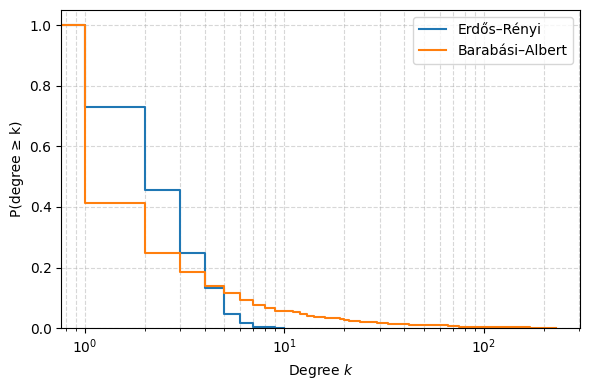

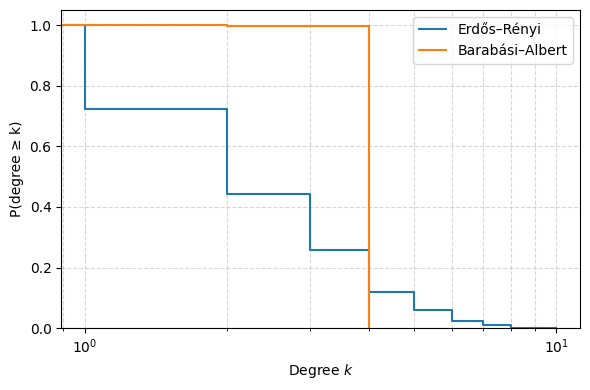

In [5]:
from subprojects.differentiable.graphs import barabasi_albert_dag_outpref, erdos_renyi_dag, compare_degree_ccdf


n = 1000
p = 3 / n      # match expected degree
m = 3

M_er = erdos_renyi_dag(n=n, p=p, seed=0)
M_ba = barabasi_albert_dag_outpref(n=n, m=m, seed=0)

compare_degree_ccdf(M_er, M_ba, mode="out")
compare_degree_ccdf(M_er, M_ba, mode="in")


# Runtime

We don't care about lambda or a good delta-l1 here

## Comparable with HP (small ns)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from subprojects.differentiable.diffalgo import diffalgo
from subprojects.differentiable.graphs import erdos_renyi_dag, barabasi_albert_dag_outpref
from subprojects.differentiable.hp import hp
from subprojects.differentiable.scm import LinearEffect, random_polynomial_scm_from_mask
from subprojects.differentiable.utils import call_with_timeout


all_results = {}
def run_rir_experiment(results, graph_type, n, num_experiments=5):
    for exp_i in range():
        if graph_type == 'erdos_renyi':
            mask = erdos_renyi_dag(n=n, p=3/n, seed=0)
        elif graph_type == 'barabasi_albert':
            mask = barabasi_albert_dag_outpref(n=n, m=3, seed=0)
        b = np.random.uniform(2, 4, size=n)

        scm = random_polynomial_scm_from_mask(
                mask, b=b, degree=2, coeff_scale=0.05, seed=1)

            # effect: use last node as "O"
        c = np.zeros(n)
        c[-1] = 1.0

        x0 = scm.forward(delta=np.zeros(n))
        robustness0 = c @ x0
        margin = abs(robustness0) * 0.8 + 1
            # thr = robustness0 - margin
        thr = robustness0 - margin

        effect = LinearEffect(c=c, thr=thr)

        interv = np.ones(n, dtype=bool)
        interv[-1] = False

        def res_hp_fn(): return hp(
                scm,
                effect,
                intervenable=interv,        # e.g. forbid outcome intervention
                max_cause_size=None,
                max_witness_size=None,
                delta_inf_bound=20.0,
            )

        try:
            res_hp = call_with_timeout(res_hp_fn, timeout=60)
        except TimeoutError:
            print('hp timeout')
            continue

        print(res_hp['status'])
        if res_hp['status'] != 'found':
            print('hp not found')
            continue

        res_diff = diffalgo(scm, effect, lmbda=0.1, step_size=0.05,
                                max_iter=5000, return_history=True, intervenable=None)
        print(res_diff["robustness"],
                  res_diff["delta_norm_l1"], res_diff["cause_size"])
        res = {
                'lambda': 0.1,
                'rir': res_hp["time"] / res_diff["time"],
                'isr': res_diff["delta_norm_l1"] / res_hp["delta_norm_l1"],
                'robustness_diff': res_diff["robustness"],
                'delta_norm_l1_diff': res_diff["delta_norm_l1"],
                'res_diff': res_diff,
                'robustness_hp': res_hp["robustness"],
                'delta_norm_l1_hp': res_hp["delta_norm_l1"],
                'res_hp': res_hp,
            }
        results[n].append(res)

for graph_type in ['erdos_renyi', 'barabasi_albert']:
    print(f'\n\n##### Graph type: {graph_type} #####')
    results = {}
    all_results[graph_type] = results
    for n in range(10, 17, 1):
        print(f'\n=== n={n} ===')
        results[n] = []
        run_rir_experiment(results, graph_type, n)



##### Graph type: erdos_renyi #####

=== n=10 ===


found
1.1583958974748048 0.0 0
found
2.5563597812794354 0.0 0
found
2.4039503953547365 0.0 0
found
2.2319544494037435 0.0 0
found
2.936460063205619 0.0 0

=== n=11 ===
found
1.8379136834975087 0.0 0
found
2.556511311741279 0.0 0
found
2.467201525545203 0.0 0
found
2.8215424292960414 0.0 0
found
2.8665176335510694 0.0 0

=== n=12 ===
found
3.2448578130855625 0.0 0
found
3.0961386127548094 0.0 0
found
2.903766322806173 0.0 0
found
2.4126196483686595 0.0 0
found
3.6349412293381533 0.0 0

=== n=13 ===
found
2.8727841472406705 0.0 0
found
3.6659851130694974 0.0 0
found
4.075429626618549 0.0 0
found
2.9793200780600237 0.0 0
found
3.166130762148892 0.0 0

=== n=14 ===
found
2.4397312014359973 0.0 0
found
1.8694498110019322 0.0 0
found
3.5315247423189042 0.0 0
found
2.292388349220056 0.0 0
found
3.2457853964032672 0.0 0

=== n=15 ===
found
3.1859975662106454 0.0 0
found
2.4447936079724277 0.0 0
found
2.998990974133463 0.0 0
found
2.6829346523686866 0.0 0
found
2.484263197823082 0.0 0

=== n=16

In [27]:
old_results = all_results.copy()

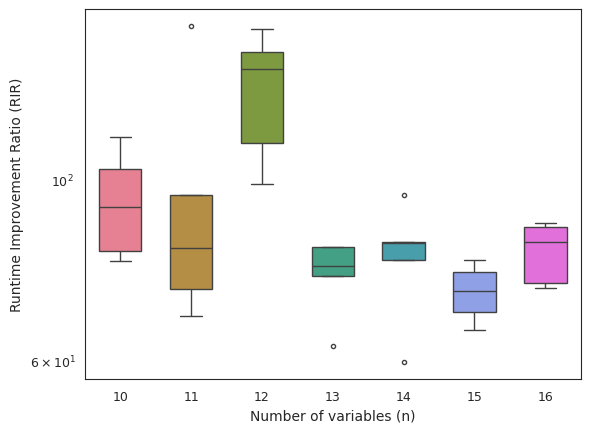

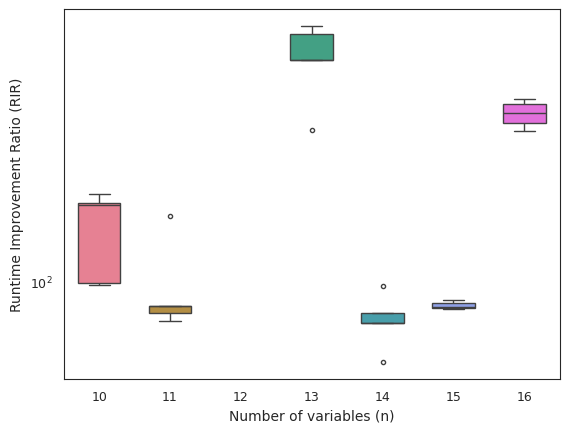

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_rir(results):
    x = list(results.keys())
    y = [
        np.mean([r["rir"] for r in results[n]])
        for n in x
    ]

    y_std = [
        np.std([r["rir"] for r in results[n]])
        for n in x
    ]

    sns.set_theme(
        context="paper",          # optimized for figures in papers
        style="white",            # clean background
        font_scale=1.2
    )

    plt.rcParams.update({
        "axes.linewidth": 0.8,
        "axes.labelsize": 10,
        "axes.titlesize": 11,
        "legend.fontsize": 9,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "lines.linewidth": 2,
        "lines.markersize": 6,
        "grid.alpha": 0.2,
    })

    sns.set_palette([
        "#0072B2",  # blue
        "#E69F00",  # orange
        "#009E73",  # green
        "#D55E00",  # red
        "#CC79A7",  # purple
    ])

    color = "#0072B2"  # NeurIPS blue

    # Line
    sns.lineplot(
        x=x,
        y=y,
        marker="o",
        linewidth=2,
        color=color,
    )

    # Std error band
    plt.fill_between(
        x,
        np.array(y) - np.array(y_std),
        np.array(y) + np.array(y_std),
        color=color,
        alpha=0.2,
        linewidth=0,
    )

    # Labels and scale
    plt.xlabel("Number of variables (n)")
    plt.ylabel("Runtime Improvement Ratio (RIR)")
    plt.yscale("log")

    plt.show()

def plot_rir_boxplot(results):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Prepare data for boxplot
    x = list(results.keys())
    y = [[r["rir"] for r in results[n]] for n in x]

    sns.set_theme(
        context="paper",
        style="white",
        font_scale=1.2
    )

    plt.rcParams.update({
        "axes.linewidth": 0.8,
        "axes.labelsize": 10,
        "axes.titlesize": 11,
        "legend.fontsize": 9,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "grid.alpha": 0.2,
    })

    sns.set_palette([
        "#0072B2",
        "#E69F00",
        "#009E73",
        "#D55E00",
        "#CC79A7",
    ])

    fig, ax = plt.subplots()

    sns.boxplot(
        data=y,
        ax=ax,
        width=0.6,
        fliersize=3,
        linewidth=1
    )

    # Set x-ticks to match n values
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x)

    ax.set_xlabel("Number of variables (n)")
    ax.set_ylabel("Runtime Improvement Ratio (RIR)")
    ax.set_yscale("log")

    plt.show()



plot_rir_boxplot(all_results['erdos_renyi'])
plot_rir_boxplot(all_results['barabasi_albert'])

## incomparable with HP (large ns)

In [82]:
def run_runtime_experiment(results, graph_type, n, num_experiments=5):
    for exp_i in range(num_experiments):
        if graph_type == 'erdos_renyi':
            mask = erdos_renyi_dag(n=n, p=3/n, seed=0)
        elif graph_type == 'barabasi_albert':
            mask = barabasi_albert_dag_outpref(n=n, m=3, seed=0)
        b = np.random.uniform(2, 4, size=n)

        scm = random_polynomial_scm_from_mask(
                mask, b=b, degree=1, coeff_scale=1, seed=1)

        # effect: use last node as "O"
        c = np.zeros(n)
        c[-1] = 1.0

        x0 = scm.forward(delta=np.zeros(n))
        robustness0 = c @ x0
        margin = abs(robustness0) * 0.8 + 1
        thr = robustness0 - margin

        effect = LinearEffect(c=c, thr=thr)

        interv = np.ones(n, dtype=bool)
        interv[-1] = False

        res_diff = diffalgo(scm, effect, lmbda=0.1, step_size=0.05,
                                max_iter=5000, return_history=True, intervenable=None)
        print(res_diff["robustness"],
                res_diff["delta_norm_l1"], res_diff["cause_size"])
        res = {
                'lambda': 0.1,
                'time_diff': res_diff["time"],
                'robustness_diff': res_diff["robustness"],
                'delta_norm_l1_diff': res_diff["delta_norm_l1"],
                'res_diff': res_diff,
            }
        results[n].append(res)

all_results = {}
for graph_type in ['erdos_renyi', 'barabasi_albert']:
    print(f'\n\n##### Graph type: {graph_type} #####')
    results = {}
    all_results[graph_type] = results
    for n in [50, 100, 150, 200]:
        print(f'\n=== n={n} ===')
        results[n] = []
        run_runtime_experiment(results, graph_type, n)



##### Graph type: erdos_renyi #####

=== n=50 ===
3.3727821255593873 0.0 0
2.9862971131961773 0.0 0
2.7366857685057164 0.0 0
3.2827323970967393 0.0 0
3.263965391274986 0.0 0

=== n=100 ===
4.119873542247378 0.0 0
3.4433237735591917 0.0 0
4.686132391717555 0.0 0
3.9334539702362354 0.0 0
3.6621472670531645 0.0 0

=== n=150 ===
2.262596792821756 0.0 0
1.782519340336865 0.0 0
4.646124011235628 0.0 0
4.24797625023608 0.0 0
2.233867273786551 0.0 0

=== n=200 ===
3.4182317600268366 0.0 0
2.262065272799893 0.0 0
2.313279144729087 0.0 0
4.520615481950257 0.0 0
3.263227965085065 0.0 0


##### Graph type: barabasi_albert #####

=== n=50 ===
23.100749655255576 0.0 0
30.352013944273597 0.0 0
25.326389073725906 0.0 0
25.05852397892282 0.0 0
21.108696248191304 0.0 0

=== n=100 ===
6.41707611471902 0.0 0
7.3993793642739245 0.0 0
6.497057553983243 0.0 0
8.203510362089784 0.0 0
7.474242433382185 0.0 0

=== n=150 ===
11.319680194189546 0.0 0
16.483873707252883 0.0 0
18.688737732843407 0.0 0
16.90631837

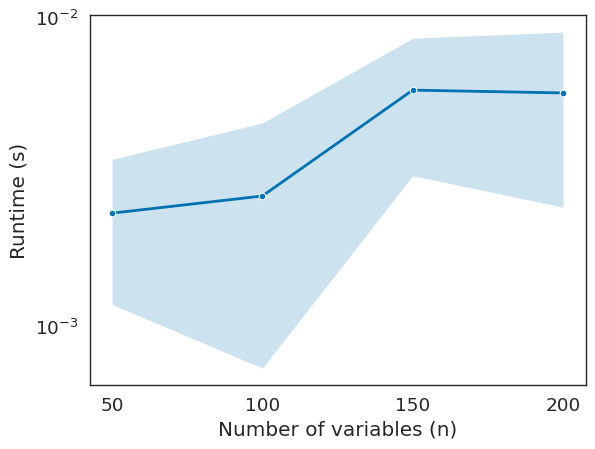

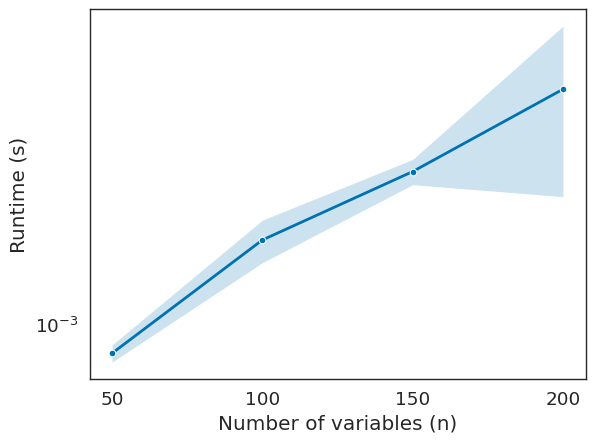

In [85]:
def plot_runtime(results):
    x = [50, 100, 150, 200]
    y = [
        np.mean([r["time_diff"] for r in results[n]])
        for n in x
    ]

    y_std = [
        np.std([r["time_diff"] for r in results[n]])
        for n in x
    ]

    sns.set_theme(
        context="paper",          # optimized for figures in papers
        style="white",            # clean background
        font_scale=1.5
    )

    # plt.rcParams.update({
    #     "axes.linewidth": 0.8,
    #     "axes.labelsize": 10,
    #     "axes.titlesize": 11,
    #     "legend.fontsize": 9,
    #     "xtick.labelsize": 9,
    #     "ytick.labelsize": 9,
    #     "lines.linewidth": 2,
    #     "lines.markersize": 6,
    #     "grid.alpha": 0.2,
    # })

    sns.set_palette([
        "#0072B2",  # blue
        "#E69F00",  # orange
        "#009E73",  # green
        "#D55E00",  # red
        "#CC79A7",  # purple
    ])

    color = "#0072B2"  # NeurIPS blue

    # Line
    sns.lineplot(
        x=x,
        y=y,
        marker="o",
        linewidth=2,
        color=color,
    )

    # Std error band
    plt.fill_between(
        x,
        np.array(y) - np.array(y_std),
        np.array(y) + np.array(y_std),
        color=color,
        alpha=0.2,
        linewidth=0,
    )

    # Labels and scale
    plt.xlabel("Number of variables (n)")
    plt.ylabel("Runtime (s)")
    plt.yscale("log")
    plt.xticks(x)

    plt.show()


plot_runtime(all_results['erdos_renyi'])
plot_runtime(all_results['barabasi_albert'])


# Sparcity
## SIR

In [87]:
def run_isr_experiment(results, graph_type, n, lmbdas):
    for exp_i in range(5):
        if graph_type == 'erdos_renyi':
            mask = erdos_renyi_dag(n=n, p=3/n, seed=0)
        elif graph_type == 'barabasi_albert':
            mask = barabasi_albert_dag_outpref(n=n, m=3, seed=0)
        b = np.random.uniform(2, 4, size=n)

        scm = random_polynomial_scm_from_mask(
            mask, b=b, degree=3, coeff_scale=0.05, seed=1)

        # effect: use last node as "O"
        c = np.zeros(n)
        c[-1] = 1.0

        x0 = scm.forward(delta=np.zeros(n))
        robustness0 = c @ x0
        margin = abs(robustness0) * 0.8 + 1
        # thr = robustness0 - margin
        thr = robustness0 - margin

        effect = LinearEffect(c=c, thr=thr)

        interv = np.ones(n, dtype=bool)
        interv[-1] = False

        # print(f'\n#{exp_i}')
        results.append([])

        def res_hp_fn(): return hp(
            scm,
            effect,
            intervenable=interv,        # e.g. forbid outcome intervention
            max_cause_size=None,
            max_witness_size=None,
            delta_inf_bound=20.0,
        )

        try:
            res_hp = call_with_timeout(res_hp_fn, timeout=15)
        except TimeoutError:
            print('hp timeout')
            continue

        if res_hp['status'] != 'found':
            print('hp not found')
            continue

        for lmbda in lmbdas:
            res_diff = diffalgo(scm, effect, lmbda=lmbda, step_size=0.05,
                                max_iter=5000, return_history=True, intervenable=None)
            print(res_diff["robustness"],
                  res_diff["delta_norm_l1"], res_diff["cause_size"])
            res = {
                'lambda': lmbda,
                'rir': res_diff["time"] / res_hp["time"],
                'isr': res_diff["delta_norm_l1"] / res_hp["delta_norm_l1"],
                'robustness_diff': res_diff["robustness"],
                'delta_norm_l1_diff': res_diff["delta_norm_l1"],
                'res_diff': res_diff,
                'robustness_hp': res_hp["robustness"],
                'delta_norm_l1_hp': res_hp["delta_norm_l1"],
                'res_hp': res_hp,
            }
            results[-1].append(res)

# lmbdas = [0.01, 0.1, 1.0, 10.0]
lmbdas = np.linspace(0.01, 2.0, 10)

all_results = {}

for graph_type in ['erdos_renyi', 'barabasi_albert']:
    print(f'\n\n##### Graph type: {graph_type} #####')
    results = {}
    all_results[graph_type] = results
    for n in [10, 16]:
        print(f'\n=== n={n} ===')
        results[n] = []
        run_isr_experiment(results[n], graph_type, n, lmbdas)



##### Graph type: erdos_renyi #####

=== n=10 ===
1.388581262958898 0.0 0
1.388581262958898 0.0 0
1.388581262958898 0.0 0
1.0184943248781053e-06 0.7691615843939713 2
1.5690794303857558e-06 0.787495580620019 3
3.5294304989719194e-07 0.8487229772667844 5
5.748191478360809e-08 0.8759989941260473 5
-1.3752651084608658e-07 0.883010919900683 5
-5.260750004509873e-07 0.8781013533296396 5
2.1349968726269708e-07 0.8872690424582372 5
1.6620680006900121 0.0 0
1.6620680006900121 0.0 0
1.6620680006900121 0.0 0
2.1382761561383745e-07 0.696042026200206 2
1.3532615379396873e-06 0.7161165754387502 2
-1.1956992862494076e-07 0.719252923159905 2
-9.172776214150247e-07 0.7927725608989896 4
-1.1742536591974329e-06 0.7983013832259173 4
7.757267042052263e-07 0.7833715495674539 4
-5.692032942761216e-07 0.7612323972237379 4
1.5406289358926495 0.0 0
1.5406289358926495 0.0 0
1.5406289358926495 0.0 0
1.052864698536382e-06 0.7865078540239346 2
2.3533404105435807e-06 0.8893108677773476 3
-2.0588825435652325e-06 0.

/home/me/phd/actual-causality/subprojects/differentiable/../../subprojects/differentiable/scm.py:195: RuntimeWarning: overflow encountered in power
  val += float(self.cube @ (x ** 3))
/home/me/phd/actual-causality/subprojects/differentiable/../../subprojects/differentiable/scm.py:163: RuntimeWarning: overflow encountered in multiply
  adj[pa_idx] += adj[i] * dfi_dpa


-0.0002139650536037152 0.10044950420153802 1

=== n=16 ===
30.83506511935247 0.32478206272153837 1
-1.3829796721154253e-06 0.9534676616167973 3
-7.436278750105885e-06 0.9035009449645616 2
-1.0352995616358385e-07 0.903499057252793 1
-1.6060391629935111e-06 0.9034991166829046 1
1.4735940183641105e-06 0.9035019678825873 2
2.1109208958591807e-07 0.903499044808261 1
1.1196577709426947e-06 0.9034990088709418 1
-5.939863001458434e-06 0.9034992881026214 1
-5.485580370390153e-06 0.9034992701339601 1


/home/me/phd/actual-causality/subprojects/differentiable/../../subprojects/differentiable/scm.py:43: RuntimeWarning: invalid value encountered in matmul
  return float(c @ x - self.thr), c.copy()


43.59371271334293 0.0 0
-2.3485709554904588e-07 1.6856302770761824 2
-1.0238142813534523e-05 1.8629744986419159 4
-1.793661983384709e-06 2.0706880107195538 3
6.837910344614784e-07 1.7787667046102662 4
4.2881200457145496e-07 1.7380451356090612 2
-9.624693042553645e-08 1.6906720497580066 2
-1.1038476488423044e-05 1.6497220966405273 2
-5.602115566105681e-06 1.6149026368574853 2
3.603041065503021e-08 1.5860268659740029 2
23.924294385753726 0.0 0
0.29776847901645453 1.3641981720225755 2
3.233436121519162e-06 1.4906227219477686 2
-2.584651121573245e-06 1.5063866338655445 2
-1.2408346528047787e-07 1.5066888792969158 2
-1.2979348253949752e-06 1.5070037597673678 2
4.5227293998806317e-07 1.5073131152039672 2
-2.852120418062043e-06 1.5076248333361568 2
-2.8023434319734974e-06 1.5065913824605368 2
-4.881622395203067e-08 1.5074929868978277 2
27.25002038963287 0.0 0
2.3471521717983794 1.59886535685656 1
0.6253428323093271 2.1677953936191225 2
6.157413540819334e-06 2.4893986285650516 3
1.120756671468

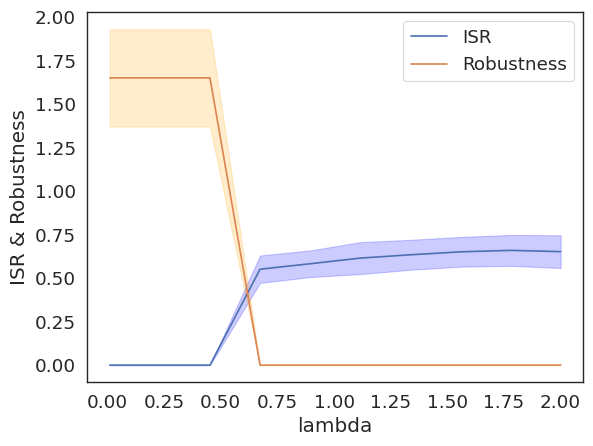

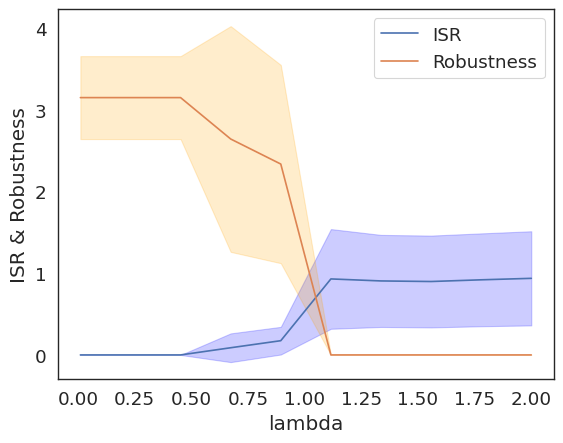

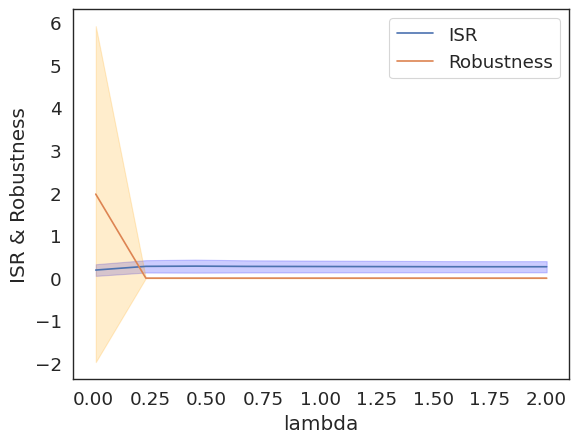

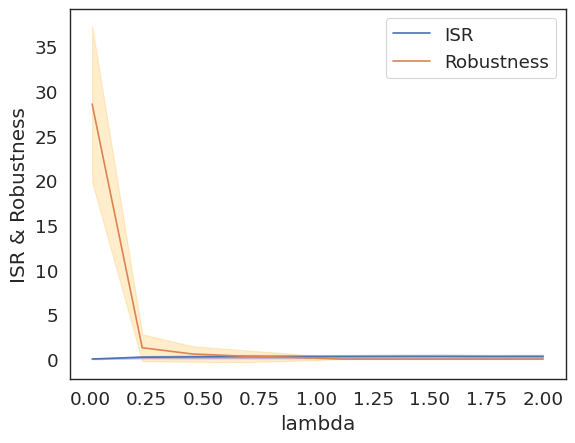

In [92]:
for graph_type in ['erdos_renyi', 'barabasi_albert']:
    for n in [10, 16]:
        means_isr = [[r['isr'] for r in rs] for rs in all_results[graph_type][n]]
        stds_isr = [[r['isr'] for r in rs] for rs in all_results[graph_type][n]]

        means_robustness = [[r['robustness_diff'] for r in rs] for rs in all_results[graph_type][n]]
        stds_robustness = [[r['robustness_diff'] for r in rs] for rs in all_results[graph_type][n]]
        plt.figure()
        sns.set_theme(
            context="paper",          # optimized for figures in papers
            style="white",            # clean background
            font_scale=1.5
        )
        # if graph_type == 'barabasi_albert':
        #     plt.yscale('log')
        # plt.title(f'Graph: {graph_type}, n={n}')
        plt.plot(lmbdas, np.mean(means_isr, axis=0), label='ISR')
        plt.fill_between(
            lmbdas,
            np.array(np.mean(means_isr, axis=0)) - np.array(np.std(stds_isr, axis=0)),
            np.array(np.mean(means_isr, axis=0)) + np.array(np.std(stds_isr, axis=0)),
            color='blue',
            alpha=0.2,
        )

        plt.plot(lmbdas, np.mean(means_robustness, axis=0), label='Robustness')
        plt.fill_between(
            lmbdas,
            np.array(np.mean(means_robustness, axis=0)) - np.array(np.std(stds_robustness, axis=0)),
            np.array(np.mean(means_robustness, axis=0)) + np.array(np.std(stds_robustness, axis=0)),
            color='orange',
            alpha=0.2,
        )
        plt.xlabel('lambda')
        plt.ylabel('ISR & Robustness')
        plt.legend()